# Work
1.請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
Ans:請參考下述比較圖例

2.請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果
Ans:
經由驗證發現,過濾器使用RMSprop且參數條件如下,能得到最佳模型效果：
Numbers of exp: 16, reduce_factor: 0.00, reduce_patient: 5
Model: "model_17"

In [25]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [26]:
train, test = keras.datasets.cifar10.load_data()

In [27]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [28]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [29]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [30]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [31]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0, 0.2, 0.4, 0.6]
redice_lr_patient = [5, 10]

In [32]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """    
    
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 9s 178us/step - loss: 1.4223 - accuracy: 0.5033 - val_loss: 1.5483 - val_accuracy: 0.4507
Epoch 11/25
50000/50000 [==============================] - 10s 209us/step - loss: 1.3983 - accuracy: 0.5119 - val_loss: 1.5398 - val_accuracy: 0.4567
Epoch 12/25
50000/50000 [==============================] - 11s 220us/step - loss: 1.3767 - accuracy: 0.5202 - val_loss: 1.5263 - val_accuracy: 0.4623
Epoch 13/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.3558 - accuracy: 0.5278 - val_loss: 1.5243 - val_accuracy: 0.4625
Epoch 14/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.3358 - accuracy: 0.5371 - val_loss: 1.5089 - val_accuracy: 0.4679
Epoch 15/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.3167 - accuracy: 0.5422 - val_loss: 1.5064 - val_accuracy: 0.4679
Epoch 16/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.2998 - accuracy: 0.5491 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 192us/step - loss: 2.3506 - accuracy: 0.2389 - val_loss: 2.1276 - val_accuracy: 0.2067
Epoch 2/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.8580 - accuracy: 0.3592 - val_loss: 1.9907 - val_accuracy: 0.2979
Epoch 3/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.7239 - accuracy: 0.4002 - val_loss: 1.8817 - val_accuracy: 0.3470
Epoch 4/25
50000/50000 [==============================] - 8s 170us/step - loss: 1.6472 - accuracy: 0.4262 - val_loss: 1.7830 - val_accuracy: 0.3806
Epoch 5/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.5939 - accuracy: 0.4462 - val_loss: 1.7183 - val_accuracy: 0.3968
Epoch 6/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.5502 - accuracy: 0.4591 - val_loss: 1.6541 - val_accuracy: 0.4190
Epoch 7/25
50000/50000 [==============================] - 8s 

50000/50000 [==============================] - 8s 169us/step - loss: 1.2353 - accuracy: 0.5741 - val_loss: 1.5046 - val_accuracy: 0.4712
Epoch 21/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.2204 - accuracy: 0.5801 - val_loss: 1.4986 - val_accuracy: 0.4773
Epoch 22/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.2059 - accuracy: 0.5854 - val_loss: 1.4910 - val_accuracy: 0.4753
Epoch 23/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.1898 - accuracy: 0.5915 - val_loss: 1.4908 - val_accuracy: 0.4773
Epoch 24/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.1758 - accuracy: 0.5964 - val_loss: 1.4921 - val_accuracy: 0.4804
Epoch 25/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.1607 - accuracy: 0.6026 - val_loss: 1.4856 - val_accuracy: 0.4796
Numbers of exp: 5, reduce_factor: 0.40, reduce_patient: 10
Model: "model_6"
__________________________________________

50000/50000 [==============================] - 8s 168us/step - loss: 1.6559 - accuracy: 0.4225 - val_loss: 1.7881 - val_accuracy: 0.3736
Epoch 5/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.5987 - accuracy: 0.4409 - val_loss: 1.7108 - val_accuracy: 0.3943
Epoch 6/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.5526 - accuracy: 0.4568 - val_loss: 1.6543 - val_accuracy: 0.4167
Epoch 7/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.5148 - accuracy: 0.4708 - val_loss: 1.6160 - val_accuracy: 0.4260
Epoch 8/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.4822 - accuracy: 0.4826 - val_loss: 1.5942 - val_accuracy: 0.4371
Epoch 9/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.4538 - accuracy: 0.4950 - val_loss: 1.5758 - val_accuracy: 0.4465
Epoch 10/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.4264 - accuracy: 0.5032 - val_loss: 1.56

Epoch 24/25
50000/50000 [==============================] - 10s 199us/step - loss: 1.1968 - accuracy: 0.5888 - val_loss: 1.4856 - val_accuracy: 0.4734
Epoch 25/25
50000/50000 [==============================] - 9s 178us/step - loss: 1.1839 - accuracy: 0.5930 - val_loss: 1.4729 - val_accuracy: 0.4805
Numbers of exp: 8, reduce_factor: 0.00, reduce_patient: 5
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________

Epoch 7/25
50000/50000 [==============================] - 10s 201us/step - loss: 1.1612 - accuracy: 0.5986 - val_loss: 1.5270 - val_accuracy: 0.4565
Epoch 8/25
50000/50000 [==============================] - 10s 205us/step - loss: 1.1186 - accuracy: 0.6162 - val_loss: 1.5273 - val_accuracy: 0.4613
Epoch 9/25
50000/50000 [==============================] - 11s 210us/step - loss: 1.0801 - accuracy: 0.6272 - val_loss: 1.4969 - val_accuracy: 0.4721
Epoch 10/25
50000/50000 [==============================] - 10s 204us/step - loss: 1.0403 - accuracy: 0.6444 - val_loss: 1.5210 - val_accuracy: 0.4636
Epoch 11/25
50000/50000 [==============================] - 10s 198us/step - loss: 1.0039 - accuracy: 0.6581 - val_loss: 1.4714 - val_accuracy: 0.4807
Epoch 12/25
50000/50000 [==============================] - 10s 192us/step - loss: 0.9717 - accuracy: 0.6679 - val_loss: 1.5383 - val_accuracy: 0.4708
Epoch 13/25
50000/50000 [==============================] - 9s 186us/step - loss: 0.9380 - accuracy: 0.6

Epoch 25/25
50000/50000 [==============================] - 16s 316us/step - loss: 0.7683 - accuracy: 0.7608 - val_loss: 1.3947 - val_accuracy: 0.5122
Numbers of exp: 11, reduce_factor: 0.20, reduce_patient: 10
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
______________________________________________

50000/50000 [==============================] - 11s 217us/step - loss: 1.3681 - accuracy: 0.5271 - val_loss: 1.5280 - val_accuracy: 0.4615
Epoch 10/25
50000/50000 [==============================] - 10s 198us/step - loss: 1.3458 - accuracy: 0.5353 - val_loss: 1.5180 - val_accuracy: 0.4683
Epoch 11/25
50000/50000 [==============================] - 16s 323us/step - loss: 1.3263 - accuracy: 0.5429 - val_loss: 1.5123 - val_accuracy: 0.4696
Epoch 12/25
50000/50000 [==============================] - 12s 245us/step - loss: 1.3074 - accuracy: 0.5492 - val_loss: 1.5075 - val_accuracy: 0.4721
Epoch 13/25
50000/50000 [==============================] - 12s 243us/step - loss: 1.2904 - accuracy: 0.5552 - val_loss: 1.5002 - val_accuracy: 0.4753
Epoch 14/25
50000/50000 [==============================] - 12s 247us/step - loss: 1.2744 - accuracy: 0.5596 - val_loss: 1.4957 - val_accuracy: 0.4779
Epoch 15/25
50000/50000 [==============================] - 12s 246us/step - loss: 1.2583 - accuracy: 0.5673 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 198us/step - loss: 2.0584 - accuracy: 0.3047 - val_loss: 2.0997 - val_accuracy: 0.2285
Epoch 2/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.6883 - accuracy: 0.4098 - val_loss: 1.9438 - val_accuracy: 0.3223
Epoch 3/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.5939 - accuracy: 0.4418 - val_loss: 1.8232 - val_accuracy: 0.3790
Epoch 4/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.5341 - accuracy: 0.4634 - val_loss: 1.7327 - val_accuracy: 0.4048
Epoch 5/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.4878 - accuracy: 0.4813 - val_loss: 1.6480 - val_accuracy: 0.4301
Epoch 6/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.4521 - accuracy: 0.4953 - val_loss: 1.6004 - val_accuracy: 0.4421
Epoch 7/25
50000/50000 [==============================] - 9s 

50000/50000 [==============================] - 9s 177us/step - loss: 1.1955 - accuracy: 0.5927 - val_loss: 1.4764 - val_accuracy: 0.4805
Epoch 21/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.1840 - accuracy: 0.5961 - val_loss: 1.4736 - val_accuracy: 0.4806
Epoch 22/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.1726 - accuracy: 0.6024 - val_loss: 1.4658 - val_accuracy: 0.4844
Epoch 23/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.1592 - accuracy: 0.6084 - val_loss: 1.4736 - val_accuracy: 0.4808
Epoch 24/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.1500 - accuracy: 0.6112 - val_loss: 1.4626 - val_accuracy: 0.4838
Epoch 25/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.1385 - accuracy: 0.6168 - val_loss: 1.4689 - val_accuracy: 0.4835
Numbers of exp: 16, reduce_factor: 0.00, reduce_patient: 5
Model: "model_17"
_________________________________________

Epoch 3/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.4833 - accuracy: 0.4841 - val_loss: 1.7877 - val_accuracy: 0.3748
Epoch 4/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.4044 - accuracy: 0.5126 - val_loss: 1.6567 - val_accuracy: 0.4116
Epoch 5/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.3481 - accuracy: 0.5315 - val_loss: 1.6255 - val_accuracy: 0.4121
Epoch 6/25
50000/50000 [==============================] - 8s 170us/step - loss: 1.2968 - accuracy: 0.5501 - val_loss: 1.6089 - val_accuracy: 0.4254
Epoch 7/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.2452 - accuracy: 0.5681 - val_loss: 1.6608 - val_accuracy: 0.4102
Epoch 8/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.2029 - accuracy: 0.5840 - val_loss: 1.5334 - val_accuracy: 0.4515
Epoch 9/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.1659 - accuracy: 0.5968 - val_

Epoch 22/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.1186 - accuracy: 0.6215 - val_loss: 1.4939 - val_accuracy: 0.4780
Epoch 23/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.1014 - accuracy: 0.6287 - val_loss: 1.5083 - val_accuracy: 0.4766
Epoch 24/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.0854 - accuracy: 0.6357 - val_loss: 1.4902 - val_accuracy: 0.4833
Epoch 25/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.0699 - accuracy: 0.6402 - val_loss: 1.5078 - val_accuracy: 0.4765
Numbers of exp: 19, reduce_factor: 0.20, reduce_patient: 10
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376

50000/50000 [==============================] - 9s 189us/step - loss: 1.5133 - accuracy: 0.4721 - val_loss: 1.6519 - val_accuracy: 0.4150
Epoch 7/25
50000/50000 [==============================] - 10s 192us/step - loss: 1.4718 - accuracy: 0.4894 - val_loss: 1.6153 - val_accuracy: 0.4283
Epoch 8/25
50000/50000 [==============================] - 10s 191us/step - loss: 1.4351 - accuracy: 0.4988 - val_loss: 1.5834 - val_accuracy: 0.4404
Epoch 9/25
50000/50000 [==============================] - 10s 190us/step - loss: 1.4018 - accuracy: 0.5135 - val_loss: 1.5656 - val_accuracy: 0.4436
Epoch 10/25
50000/50000 [==============================] - 10s 197us/step - loss: 1.3700 - accuracy: 0.5249 - val_loss: 1.5537 - val_accuracy: 0.4539
Epoch 11/25
50000/50000 [==============================] - 10s 191us/step - loss: 1.3445 - accuracy: 0.5353 - val_loss: 1.5340 - val_accuracy: 0.4637
Epoch 12/25
50000/50000 [==============================] - 10s 193us/step - loss: 1.3174 - accuracy: 0.5447 - val_lo

Numbers of exp: 22, reduce_factor: 0.60, reduce_patient: 5
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_67 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________

50000/50000 [==============================] - 8s 166us/step - loss: 1.3692 - accuracy: 0.5249 - val_loss: 1.5553 - val_accuracy: 0.4583
Epoch 11/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.3413 - accuracy: 0.5362 - val_loss: 1.5364 - val_accuracy: 0.4652
Epoch 12/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.3175 - accuracy: 0.5446 - val_loss: 1.5275 - val_accuracy: 0.4626
Epoch 13/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.2920 - accuracy: 0.5547 - val_loss: 1.5252 - val_accuracy: 0.4625
Epoch 14/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.2688 - accuracy: 0.5627 - val_loss: 1.5074 - val_accuracy: 0.4686
Epoch 15/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.2473 - accuracy: 0.5707 - val_loss: 1.5063 - val_accuracy: 0.4686
Epoch 16/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.2272 - accuracy: 0.5786 - val_loss:

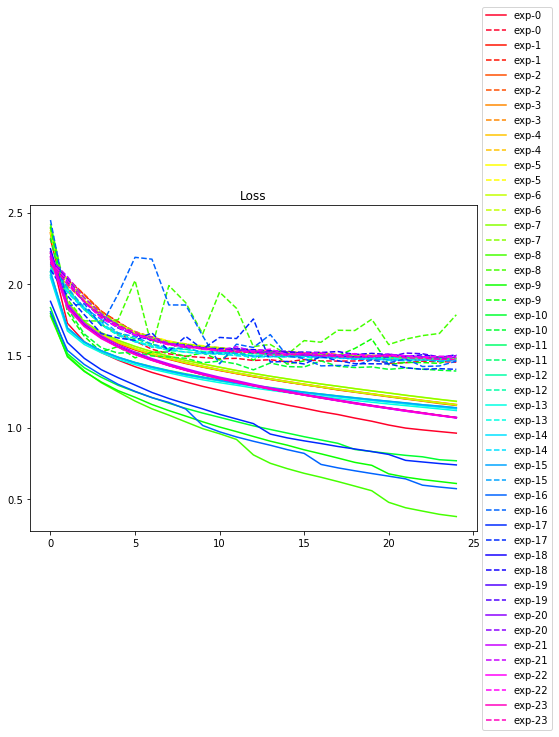

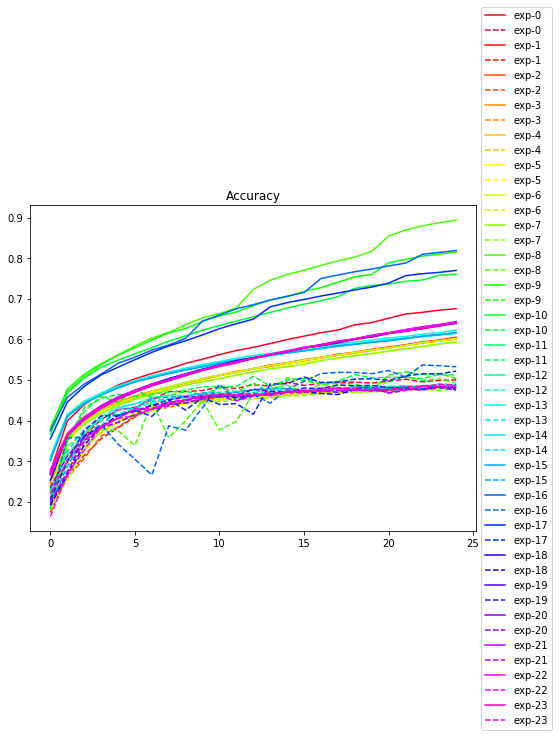

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()